# Introduction
Text Classification is one of the most important problems in Natural language processing. the goal of text classification is to automatically classify the text documents into one or more defined categories. this project aims to classify text documents from gutenberg's online book into thier author. Text classification is an example of supervised machine learning task since a labelled dataset containing text documents and their labels is used for train classifier. Text classification pipeline consists of four main components:

1. **Data Preparation:** this step includes importing the book library, partitioning data, cleaning, and performing basic pre-processing. the dataset is then splitted into train and validation sets. 
2. **Feature Engineering:** the raw dataset is transformed into vectors that can be used in a machine learning model. this step includes creating new features.
3. **Model Training:** Building up the model and train the labelled data.
4. **Model Evaluation:** evaluate the performance of the model on unseen data "test data".

we use Gridsearch for selecting the best estimators among different parameters of the model, and we use cross validation to generalize the model with k-fold = 10. in addition, we calculate bias-variance of the best estimators among different features to select the best feature. we use  visualizations for analysis of data according to model's training accuracy, test accuracy, and bias-variance measurements among a variety of features. Finally, we do some error analysis like confusion matrix and classification report to show more details about the classification results. 

# libraries 
for dataset preparation, feature engineering, model training & Evaluation 

In [1]:
import nltk
import re
import pandas as pd
import numpy as np
from nltk.corpus import gutenberg
import random
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing , decomposition ,ensemble


from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from keras.preprocessing import text, sequence
from mlxtend.evaluate import bias_variance_decomp 

# Data Preparation
It's the process of preparing data to be ready for the model. this project includes: 
1. Partitioning the whole text into 200 text documents that will be used as text data.
2. Cleaning the text from stopwords and panctuations.
3. pre-processing through stemming and lemmatization.
4. Split data into training & test.

* # Select 5 books whose authors from the same generation.

In [2]:
samples = gutenberg.fileids() #list all parts in gutenberg's book
print("There are {} samples in the book\n".format(len(samples)))
print("Samples in the book are:\n {}".format(samples))

#Generalize the program so that you can replicate that for multiple books.
# selected_samples = random.sample(samples,k = 5) #Take a sufficient sample of Gutenberg's digital book.
selected_samples = [samples[0] , samples[4] , samples[10] , samples[14], samples[17]] #sample of authors from the same generation
#k : number of selected books that will partition them and it is selected randomly between(1 : number of total book samples)
print("\nSelected samples are: {}\n".format(selected_samples))
print('Number of selected samples is: {}'.format(len(selected_samples)))


There are 18 samples in the book

Samples in the book are:
 ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']

Selected samples are: ['austen-emma.txt', 'blake-poems.txt', 'chesterton-thursday.txt', 'shakespeare-caesar.txt', 'whitman-leaves.txt']

Number of selected samples is: 5


* # Partioning Data, 200 partitions, 100 words per partition. 
Returns a list of tuples that contain author's name as a label and the text document as text data. 

In [3]:
documents = []
part = ''
# documents = {} #dictionary for saving text label as a key and the text partition as its value
for selected_sample in selected_samples:
    words = gutenberg.words(selected_sample)
    for i in range(0, 200): #creating 200 partition
        random_word_index= random.choice(range(len(words))) #Create (random?!) samples of 200 partitions of the book.
        if random_word_index <= (len(words)):
            part = words[random_word_index : random_word_index+100]
        else: 
            random_word_index = random_word_index - 100
            part = words[random_word_index : random_word_index+100]
        partition = " ".join(part)
        partition_label = selected_sample.split('.')[0] #label of partation = name of the author
        documents.append((partition_label , partition))
len(documents)

1000

* # Convert list of tuples of (partition_author , partition) to Dataframe

In [4]:
doc_df =  pd.DataFrame(documents, columns=["author", "text"])
doc_df

,author,text
0,austen-emma,"other change , he could not agree to . He had ..."
1,austen-emma,"the same caution , perhaps , in judging of the..."
2,austen-emma,"of the party , she could not tell . They , in ..."
3,austen-emma,"inferior in talent , and all the elegancies of..."
4,austen-emma,the difference of the journey ;-- only conside...
...,...,...
995,whitman-leaves,-- and no less in myself than the whole of the...
996,whitman-leaves,The countless ( nineteen - twentieths ) low an...
997,whitman-leaves,an American point of view . I will sing the so...
998,whitman-leaves,and publish yourself of your own Personality ....


* # Cleaning & Preprocessing

In [5]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

# create a re-usable function:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True):#, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
doc_df['clean_text'] = doc_df['text'].apply(lambda txt: utils_preprocess_text(txt))
doc_df

,author,text,clean_text
0,austen-emma,"other change , he could not agree to . He had ...",change could agree thinking deeply intently fi...
1,austen-emma,"the same caution , perhaps , in judging of the...",caution perhaps judging conduct one individual...
2,austen-emma,"of the party , she could not tell . They , in ...",party could tell different home different way ...
3,austen-emma,"inferior in talent , and all the elegancies of...",inferior talent elegancies mind want equality ...
4,austen-emma,the difference of the journey ;-- only conside...,difference journey consider great would hundre...
...,...,...,...
995,whitman-leaves,-- and no less in myself than the whole of the...,le whole mannahatta singing song ever united l...
996,whitman-leaves,The countless ( nineteen - twentieths ) low an...,countless nineteen twentieth low evil crude sa...
997,whitman-leaves,an American point of view . I will sing the so...,american point view sing song companionship sh...
998,whitman-leaves,and publish yourself of your own Personality ....,publish personality unfolded fold unfolded fol...


* # Split data to train and test for further prediction

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(doc_df['clean_text'], doc_df['author'], test_size=0.2, random_state=0)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Feature Engineering

* # Count Vectors as features (BOW)
Count Vector is a matrix notation of the dataset in which every row represents a document from the text, every column represents a term from the text, and every cell represents the frequency count of a particular term in a particular document.

In [8]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train)
xtest_count =  count_vect.transform(X_test)

* # TF-IDF Vectors as features

TF-IDF score represents the relative importance of a term in the document and the entire text. TF-IDF score is composed by two terms:

-the first computes the normalized Term Frequency (TF), 

-the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)
IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams):

1. Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

2. N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

In [9]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
xtrain_tfidf =  tfidf_vect.transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

* # Topic Models as features (LDA) : Latent Dirichlet Allocation

Topic Modelling is a technique to identify the groups of words (called a topic) from a collection of documents that contains best information in the collection. I have used Latent Dirichlet Allocation for generating Topic Modelling Features. LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

In [10]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

# view the topic models
n_top_words = 100
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    
topic_summaries[0] #the first document resulted from the model

'weep deep followed lie maid tiger gone saw said sleeping fear dell lonely palace vision led among child dwell asleep wild day lyca hair surprise shoulder flowed follow golden wolvish howl care gentleman horse look wondering crown filled armed behold gold spirit head hat growl top chimney lion little upon sweeper stand black thing opened professor describe noise note leapt snow coat frock cry woe seat thy stone elm peasant grunted wash arc cart soleil nearly clump sitting descended le leaping spoke travelling apology enemy fragmentary improvisation bravado crazy wishing breach bench sucked plain dry hastily clinch embankment alarmed rattle'

* # N-gram frequent words visualization 
Top 10 frequently  words for austen_emma's book.

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


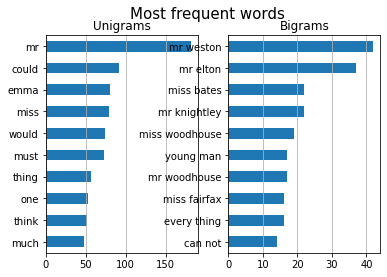

In [11]:
top=10
nltk.download('punkt')
## for vectorizer
from sklearn import feature_extraction, manifold

y = "austen-emma"
corpus = doc_df[doc_df["author"]==y]["clean_text"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
    
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

* # Visualizing the most frequent words through wordcloud library.

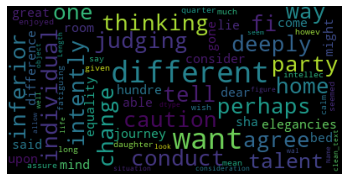

In [12]:
import wordcloud
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

* # Word Embeddings & PCA for dimensionality reduction for visualization
A word embedding is a form of representing words and documents using a dense vector representation. The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.

    we use gensim library for word embedding model.
    
    Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. 

In [13]:
## for vectorizer
from sklearn import feature_extraction, manifold
## for word embedding
import gensim.downloader as gensim_api
## for topic modeling
import gensim
nlp = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


* # **Word Embedding for "friend"**

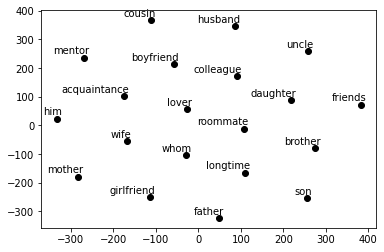

In [14]:
## find closest vectors
word = 'friend'
labels, X, x, y = [], [], [], []
for t in nlp.most_similar(word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])
## reduce dimensions
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])
## plot
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

# Classification & Evaluation (CV = 10)
Classification is the step of building the model to categorize the corpus to its author. we use a variety of classifiers such as :
1. Support Vector Machine (SVM)
2. Decision Tree
3. K-nearest neighbour (KNN)

Next, we use classification metrics for evaluation of the model on test data. the classification metrics include:
* Accuracy_score
* Confusion matrix 
* Classification report

In [15]:
# function for model training
def train_model(text_pipe, parameters ,X_train, y, X_test, is_neural_net=False):
    # fit the training dataset on the classifier
    gs_clf = GridSearchCV(text_pipe, parameters, cv=10, n_jobs=-1 , return_train_score = True)

    #training
    gs_clf = gs_clf.fit(X_train , y)

    best_estimator = gs_clf.best_estimator_
    acc = gs_clf.best_score_
    
   
    # predict the labels on test dataset
    predictions = best_estimator.predict(X_test)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return acc  , predictions , best_estimator


#list of data according to the applied feature.
features_out_train = [xtrain_count , xtrain_tfidf , xtrain_tfidf_ngram ] #training data
features_out_test = [xtest_count , xtest_tfidf , xtest_tfidf_ngram ] #test data
features = ['BOW' , 'TFIDF' , 'TFIDF_Ngram' ]

In [16]:
#initializing lists for visualization purposes
models = ['SVM' , 'DEC_TREE' , 'KNN']
SVM=[ ]
tree =[]
knn =[]

# SVM Classifier

Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. The model extracts a best possible hyper-plane / line that segregates the two classes. in this project we searched for variety of parameters and select the best estimator.

The following processes are:
* Creating the pipeline of the classifier.
* fitting the classifier with cross validation.
* Evaluation of the model on test data
* Bias-Variance measurements
* Error analysis 

BOW :	 10 fold mean Accuracy is: 0.98 ,	 Test Accuracy is: 0.99 
BOW :	 Average bias: 0.010 , 	 Average variance: 0.022
==========Classsification Report of feature: BOW	 ============
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       0.98      1.00      0.99        49
           2       1.00      0.98      0.99        41
           3       1.00      1.00      1.00        44
           4       1.00      0.97      0.99        40

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

TFIDF :	 10 fold mean Accuracy is: 0.99 ,	 Test Accuracy is: 0.99 
TFIDF :	 Average bias: 0.005 , 	 Average variance: 0.015
==========Classsification Report of feature: TFIDF	 ============
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.98     

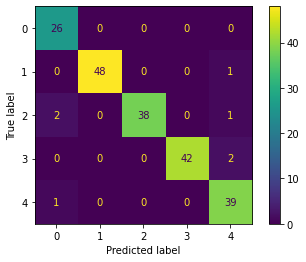

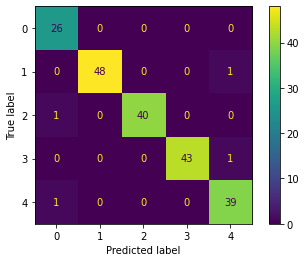

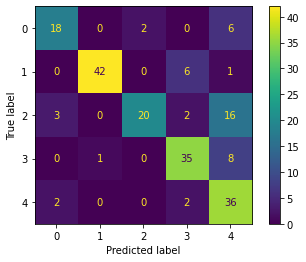

In [17]:
text_pipe = Pipeline([
    ('estimator',SVC())])


parameters ={
    'estimator__C' : [0.1, 1, 10],
    'estimator__gamma':[1, 0.1, 0.01],
    'estimator__kernel':['linear' , 'rbf']
    
}

for i in range(len(features_out_train)):
    acc  , predictions , best_estimator   = train_model(text_pipe , parameters, features_out_train[i], y_train, features_out_test[i])
    test_acc = accuracy_score(predictions , y_test)
    print(f"{features[i]} :\t 10 fold mean Accuracy is: {acc:.2f} ,\t Test Accuracy is: {test_acc:.2f} ")
    #Calculating bias-variance  
    _, avg_bias, avg_var = bias_variance_decomp(best_estimator, features_out_train[i], y_train, features_out_test[i], y_test, loss='0-1_loss',random_seed=123)
    print(f'{features[i]} :\t Average bias: {avg_bias:.3f} , \t Average variance: {avg_var:.3f}')
    SVM.append((acc , test_acc , avg_bias , avg_var))
    #Classification report of each feature
    print(f'==========Classsification Report of feature: {features[i]}\t ============\n',classification_report(y_test,predictions))
    #confusion matrix plot
    plot_confusion_matrix(best_estimator ,features_out_test[i] , y_test )
    plt.show

# Decision Tree Classifier

BOW :	 10 fold mean Accuracy is: 0.81 ,	 Test Accuracy is: 0.80 
BOW :	 Average bias: 0.105 , 	 Average variance: 0.184
==========Classsification Report of feature: BOW	 ============
               precision    recall  f1-score   support

           0       0.77      0.88      0.82        26
           1       0.85      0.84      0.85        49
           2       0.67      0.68      0.67        41
           3       0.97      0.89      0.93        44
           4       0.70      0.70      0.70        40

    accuracy                           0.80       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.80      0.80      0.80       200

TFIDF :	 10 fold mean Accuracy is: 0.81 ,	 Test Accuracy is: 0.84 
TFIDF :	 Average bias: 0.110 , 	 Average variance: 0.188
==========Classsification Report of feature: TFIDF	 ============
               precision    recall  f1-score   support

           0       0.80      0.92      0.86        26
           1       0.84     

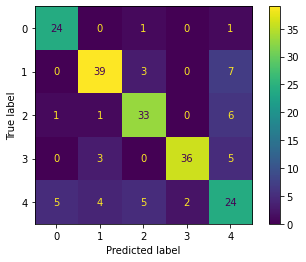

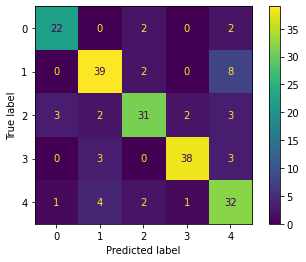

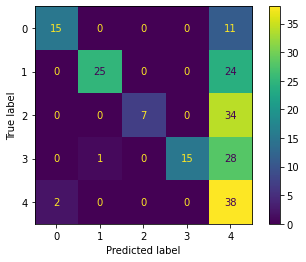

In [18]:
text_pipe = Pipeline([
    ('estimator',DecisionTreeClassifier())])


parameters ={
    'estimator__criterion':['gini', 'entropy'],
    'estimator__max_depth':[10,12,14,16,18,20,24,28,30,32,36,40],
}

for i in range(len(features_out_train)):
    acc  , predictions , best_estimator   = train_model(text_pipe , parameters, features_out_train[i], y_train, features_out_test[i])
    test_acc = accuracy_score(predictions , y_test)
    print(f"{features[i]} :\t 10 fold mean Accuracy is: {acc:.2f} ,\t Test Accuracy is: {test_acc:.2f} ")
    #Calculating bias-variance  
    _, avg_bias, avg_var = bias_variance_decomp(best_estimator, features_out_train[i], y_train, features_out_test[i], y_test, loss='0-1_loss',random_seed=123)
    print(f'{features[i]} :\t Average bias: {avg_bias:.3f} , \t Average variance: {avg_var:.3f}')
    tree.append((acc , test_acc , avg_bias , avg_var))
    #Classification report of each feature
    print(f'==========Classsification Report of feature: {features[i]}\t ============\n',classification_report(y_test,predictions))
    #confusion matrix plot
    plot_confusion_matrix(best_estimator ,features_out_test[i] , y_test )
    plt.show

# KNN Classifier

BOW :	 10 fold mean Accuracy is: 0.71 ,	 Test Accuracy is: 0.72 
BOW :	 Average bias: 0.285 , 	 Average variance: 0.139
==========Classsification Report of feature: BOW	 ============
               precision    recall  f1-score   support

           0       0.41      0.96      0.57        26
           1       0.75      0.96      0.84        49
           2       0.88      0.56      0.69        41
           3       1.00      0.89      0.94        44
           4       0.91      0.25      0.39        40

    accuracy                           0.72       200
   macro avg       0.79      0.72      0.69       200
weighted avg       0.82      0.72      0.71       200

TFIDF :	 10 fold mean Accuracy is: 0.91 ,	 Test Accuracy is: 0.92 
TFIDF :	 Average bias: 0.080 , 	 Average variance: 0.091
==========Classsification Report of feature: TFIDF	 ============
               precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.92     

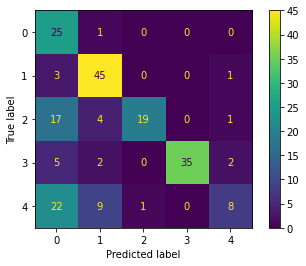

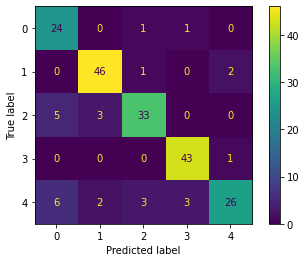

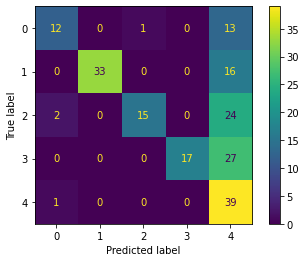

In [19]:
text_pipe = Pipeline([
    ('estimator',KNeighborsClassifier())])


parameters ={
    'estimator__n_neighbors':[2,3,4,5],
    'estimator__weights':['uniform', 'distance'],
}
for i in range(len(features_out_train)):
    acc  , predictions , best_estimator   = train_model(text_pipe , parameters, features_out_train[i], y_train, features_out_test[i])
    test_acc = accuracy_score(predictions , y_test)
    print(f"{features[i]} :\t 10 fold mean Accuracy is: {acc:.2f} ,\t Test Accuracy is: {test_acc:.2f} ")
    #Calculating bias-variance  
    _, avg_bias, avg_var = bias_variance_decomp(best_estimator, features_out_train[i], y_train, features_out_test[i], y_test, loss='0-1_loss',random_seed=123)
    print(f'{features[i]} :\t Average bias: {avg_bias:.3f} , \t Average variance: {avg_var:.3f}')
    knn.append((acc , test_acc , avg_bias , avg_var))
    #Classification report of each feature
    print(f'==========Classsification Report of feature: {features[i]}\t ============\n',classification_report(y_test,predictions))
    #confusion matrix plot
    plot_confusion_matrix(best_estimator ,features_out_test[i] , y_test )
    plt.show

# Training 10-fold mean Accuracy Visualization

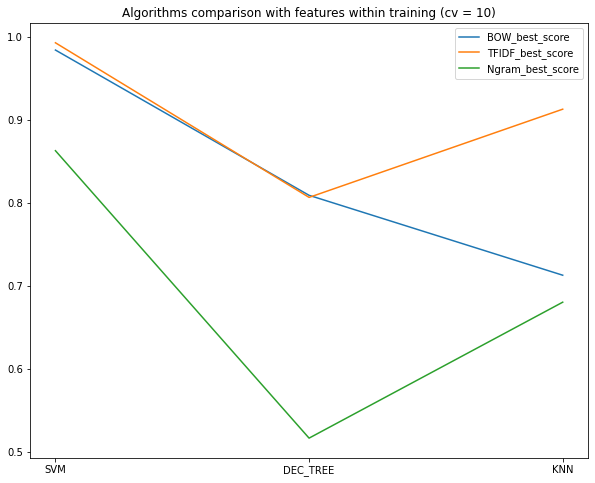

In [20]:
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [SVM[0][0], tree[0][0] , knn[0][0]] , label = 'BOW_best_score')
plt.plot(models , [SVM[1][0], tree[1][0] , knn[1][0]] , label = 'TFIDF_best_score')
plt.plot(models , [SVM[2][0], tree[2][0] , knn[2][0]] , label = 'Ngram_best_score')
plt.legend()
plt.title('Algorithms comparison with features within training (cv = 10)')
plt.show()

# Test Accuracy Visualization

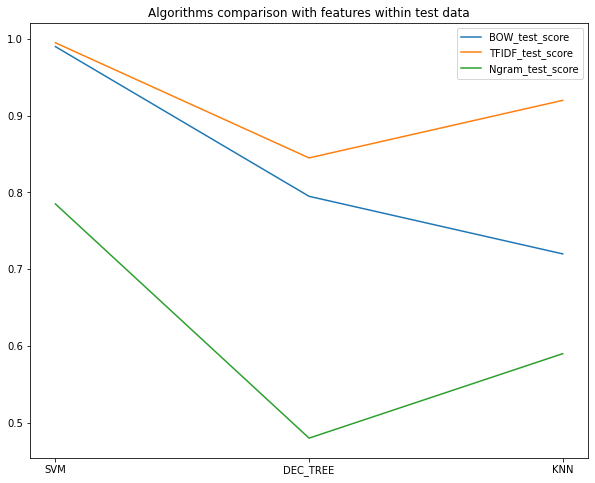

In [21]:
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [SVM[0][1], tree[0][1] , knn[0][1]] , label = 'BOW_test_score')
plt.plot(models , [SVM[1][1], tree[1][1] , knn[1][1]] , label = 'TFIDF_test_score')
plt.plot(models , [SVM[2][1], tree[2][1] , knn[2][1]] , label = 'Ngram_test_score')
plt.legend()
plt.title('Algorithms comparison with features within test data')
plt.show()

# Bias_Variance Visualization

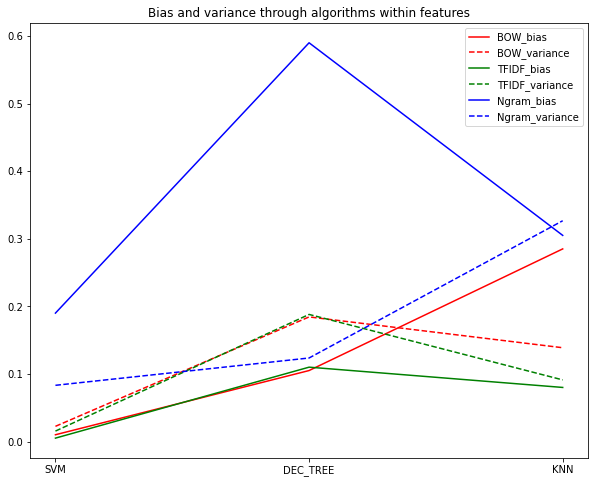

In [22]:
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [SVM[0][2], tree[0][2] , knn[0][2]] ,'r', label = 'BOW_bias')
plt.plot(models , [SVM[0][3], tree[0][3] , knn[0][3]] ,'r--', label = 'BOW_variance')
plt.plot(models , [SVM[1][2], tree[1][2] , knn[1][2]] ,'g', label = 'TFIDF_bias')
plt.plot(models , [SVM[1][3], tree[1][3] , knn[1][3]] ,'g--', label = 'TFIDF_variance')
plt.plot(models , [SVM[2][2], tree[2][2] , knn[2][2]] , 'b',label = 'Ngram_bias')
plt.plot(models , [SVM[2][3], tree[2][3] , knn[2][3]] , 'b--',label = 'Ngram_variance')
plt.legend()
plt.title('Bias and variance through algorithms within features')
plt.show()

# from graph we conclude that the champion model is "SVM" and the best feature to be selected is "TFIDF".
max mean 10-fold accuracy score / test score.

min bias/variance

In [23]:
print('***********************The champion model is "SVM", while the best feature is "TFIDF" in performance!***********************')


***********************The champion model is "SVM", while the best feature is "TFIDF" in performance!***********************
